<a href="https://colab.research.google.com/github/keyush06/Topic-Modelling-with-Latent-Dirichlet-Allocation-LDA-/blob/master/Topic_Modelling_KeyushShah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [4]:
## Importing the necessary libraries
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from pprint import pprint
import matplotlib.colors as mcolors

##Mute the warnings
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import gensim, spacy, logging

from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel

# spacy for lemmatization
import spacy

In [5]:
papers = pd.read_csv('/content/drive/MyDrive/Datasets/Papers.csv')
papers.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


## **Exploratory data analysis and Data Cleaning**





In [6]:
print(f'The shape of the data set is {papers.shape} \nThe columns are : {papers.columns}')
print('='*100)
print(papers.info())

The shape of the data set is (7241, 7) 
The columns are : Index(['id', 'year', 'title', 'event_type', 'pdf_name', 'abstract',
       'paper_text'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7241 entries, 0 to 7240
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          7241 non-null   int64 
 1   year        7241 non-null   int64 
 2   title       7241 non-null   object
 3   event_type  2422 non-null   object
 4   pdf_name    7241 non-null   object
 5   abstract    7241 non-null   object
 6   paper_text  7241 non-null   object
dtypes: int64(2), object(5)
memory usage: 396.1+ KB
None


Here we note that the event_type has sum null vales but apart from that no other columns have the null values. We shall further count the number of values in that column.

In [7]:
print('The count of null values in the event_type column is %d' % papers.isnull().sum()['event_type'])
print('Proportion of null values in this column : ', papers.isnull().sum()['event_type']/papers.shape[0]*100,'%')

The count of null values in the event_type column is 4819
Proportion of null values in this column :  66.55158127330479 %


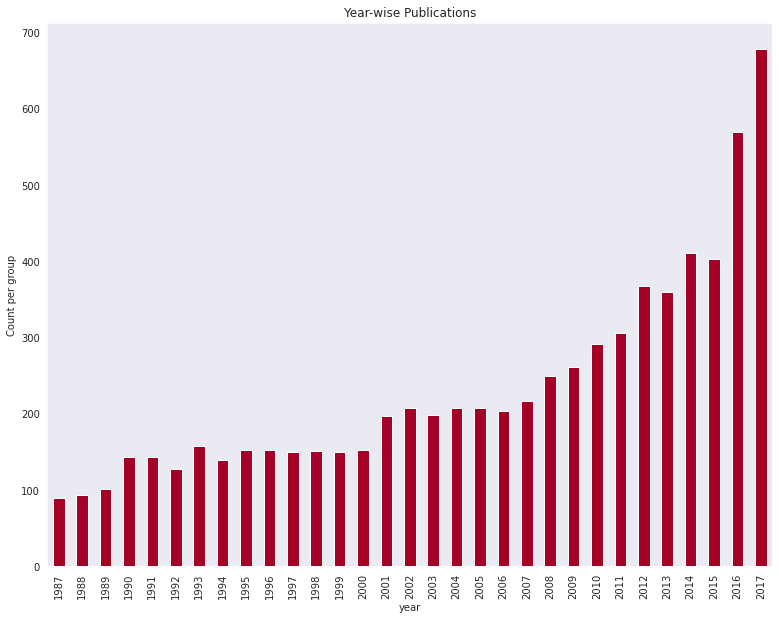

Hence most number of publications were in 2017


In [8]:
from termcolor import colored
plt.figure(figsize = (13,10))
sns.set_style("dark")
groups = papers.groupby('year')
groups.size().plot(kind='bar',colormap = 'RdYlGn')
plt.xlabel('year')
plt.ylabel('Count per group')
plt.title('Year-wise Publications')
plt.show()

print(colored('Hence most number of publications were in 2017','blue',attrs=['bold']))

In [9]:
pd.set_option('display.max_colwidth', None)
papers['paper_text'].head(1)

## Here we see that our text is quite huge. 

0    767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABASE\nAND ITS APPLICATIONS\nHisashi Suzuki and Suguru Arimoto\nOsaka University, Toyonaka, Osaka 560, Japan\nABSTRACT\nAn efficient method of self-organizing associative databases is proposed together with\napplications to robot eyesight systems. The proposed databases can associate any input\nwith some output. In the first half part of discussion, an algorithm of self-organization is\nproposed. From an aspect of hardware, it produces a new style of neural network. In the\nlatter half part, an applicability to handwritten letter recognition and that to an autonomous\nmobile robot system are demonstrated.\n\nINTRODUCTION\nLet a mapping f : X -+ Y be given. Here, X is a finite or infinite set, and Y is another\nfinite or infinite set. A learning machine observes any set of pairs (x, y) sampled randomly\nfrom X x Y. (X x Y means the Cartesian product of X and Y.) And, it computes some\nestimate j : X -+ Y of f to make small, the estimation 

**Approx. Frequency of words in the text**

In [10]:
papers['No._of_words'] = papers['paper_text'].apply(lambda x : len(str(x).split()))
pd.set_option('display.max_colwidth',60)
papers.head()

,id,year,title,event_type,pdf_name,abstract,paper_text,No._of_words
0,1,1987,Self-Organization of Associative Database and Its Applic...,NaN,1-self-organization-of-associative-database-and-its-appl...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABASE\nAND IT...,3703
1,10,1987,A Mean Field Theory of Layer IV of Visual Cortex and Its...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-cortex-and-...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISUAL CORTEX\...,2615
2,100,1988,Storing Covariance by the Associative Long-Term Potentia...,NaN,100-storing-covariance-by-the-associative-long-term-pote...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\nLONG?TERM ...,3012
3,1000,1994,Bayesian Query Construction for Neural Network Models,NaN,1000-bayesian-query-construction-for-neural-network-mode...,Abstract Missing,Bayesian Query Construction for Neural\nNetwork Models\n...,3296
4,1001,1994,"Neural Network Ensembles, Cross Validation, and Active L...",NaN,1001-neural-network-ensembles-cross-validation-and-activ...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, and Active ...",3430


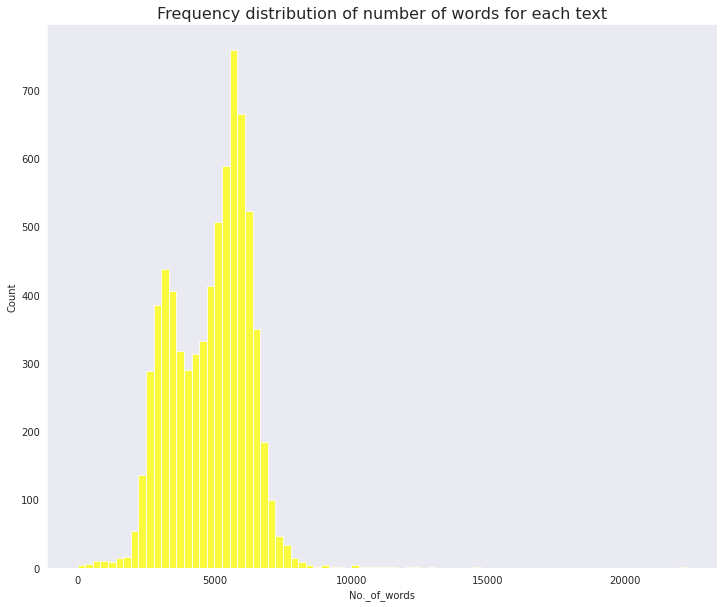

In [11]:
##Plotting the number of words
plt.figure(figsize=(12,10))
sns.histplot(papers['No._of_words'], bins=80, kde = False, color = 'yellow')
plt.title("Frequency distribution of number of words for each text", size=16)
plt.show()

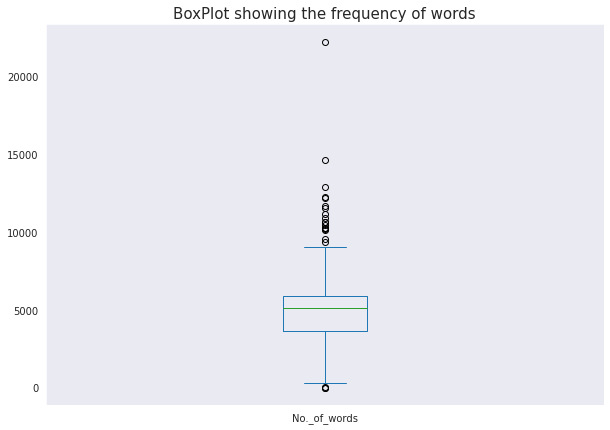

In [12]:
plt.figure(figsize = (10,7))
papers['No._of_words'].plot(kind='box')
plt.title('BoxPlot showing the frequency of words',size=15)
plt.show()

In [13]:
papers[papers['No._of_words']>6000].index

Int64Index([  67,   96,  102,  163,  191,  393,  400,  426,  447,  497,
            ...
            6943, 6944, 6945, 6946, 6947, 7045, 7105, 7141, 7172, 7178],
           dtype='int64', length=1565)

**Preprocessing on the Title column**

In [14]:
nltk.download('all')
stop = set(stopwords.words('english'))

#Removing the punctuations
def remove_punc(text):
  puncfree = "".join([i for i in text if i not in string.punctuation])
  return puncfree


def clean_text(text):
  puncfree = remove_punc(text)
  tokenize = word_tokenize(puncfree)
  filtered = " ".join([w.lower() for w in tokenize if w.lower() not in stop])
  filtered = filtered.replace(r'[^a-zA-Z]+',"") #remove all characters except the ones mentioned
  filtered = filtered.lstrip()
  filtered = re.sub(r'\b\d+\b', '', filtered) #removing the digits
  return filtered

papers['cleaned_title'] = papers['title'].apply(clean_text)
papers['cleaned_title'].head(1)

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

0    selforganization associative database applications
Name: cleaned_title, dtype: object

In [15]:
papers['cleaned_title'].head()

0             selforganization associative database applications
1    mean field theory layer iv visual cortex application art...
2    storing covariance associative longterm potentiation dep...
3              bayesian query construction neural network models
4      neural network ensembles cross validation active learning
Name: cleaned_title, dtype: object

***Creating a WordCloud for the Titles***

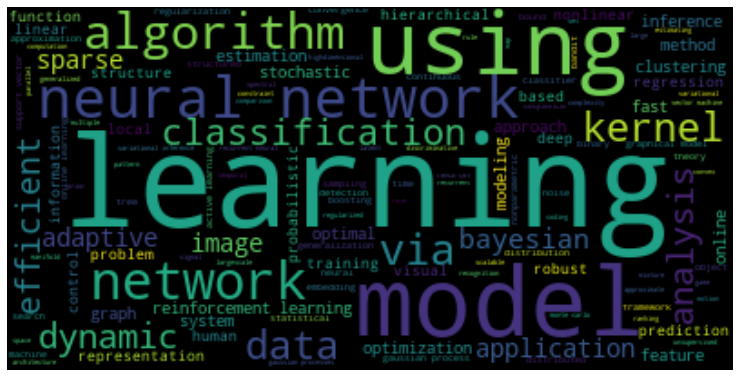

In [16]:
def create_wordcloud(data,col:str):
  s = " ".join(data[col])
  wc = WordCloud()
  wc.generate(s)
  return wc.to_image()

fig=plt.figure(figsize=(13,18))
plt.axis("off")
plt.imshow(create_wordcloud(papers,'cleaned_title'),interpolation='bilinear')

**Now doing the same with the paper_text column**

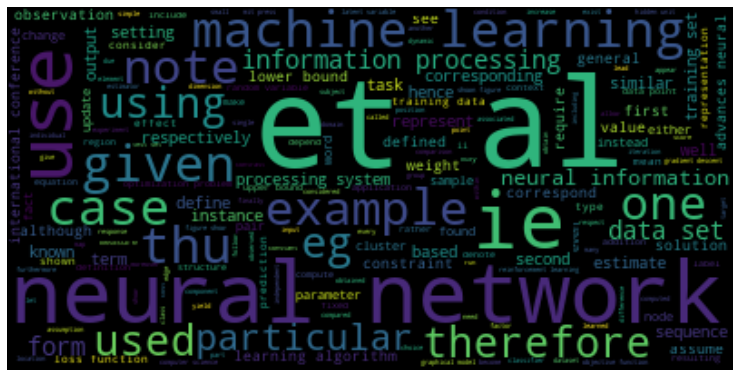

In [17]:
papers['cleaned_text'] = papers['paper_text'].apply(clean_text)
papers['cleaned_text'].head()

print('='*100)

fig=plt.figure(figsize=(13,15))
plt.axis("off")
plt.imshow(create_wordcloud(papers,'cleaned_text'),interpolation='bilinear')

In [18]:
pd.set_option('display.max_colwidth', 300)
papers['cleaned_text'].head(1)

0     selforganization associative database applications hisashi suzuki suguru arimoto osaka university toyonaka osaka  japan abstract efficient method selforganizing associative databases proposed together applications robot eyesight systems proposed databases associate input output first half part ...
Name: cleaned_text, dtype: object

### **Most occuring words in the Paper_text**

In [19]:
def most_occuring(data, count_vec):
  words = count_vec.get_feature_names()
  total_count_words = np.zeros(len(words))
  for i in data:
    total_count_words += i.toarray()[0] ##This will give 1-D array

  counters = zip(words,total_count_words)
  counters = sorted(counters, key = lambda x:x[1], reverse=True)[0:8] ## Will give the top 8 words
  words = [w[0] for w in counters]
  counts = [w[1] for w in counters]
  x_positions = np.arange(len(words))
  plt.figure(figsize=(8,8))
  plt.bar(x_positions, counts,align='center', color = 'green')
  plt.xticks(x_positions, words, rotation=90) 
  plt.xlabel('words')
  plt.ylabel('counts')
  plt.title('8 most common words')
  plt.show()
  


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


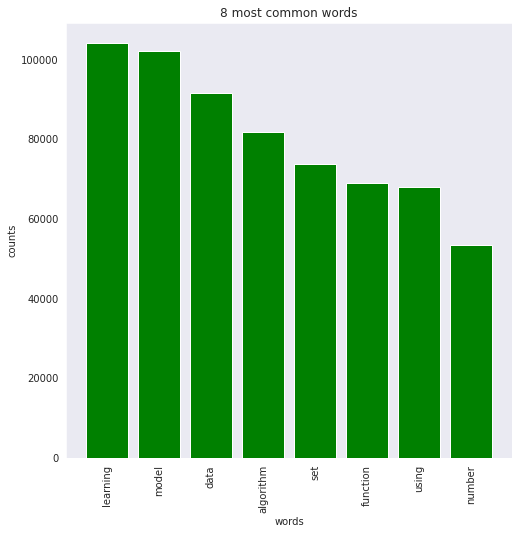

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(stop_words='english')
data = count_vectorizer.fit_transform(papers['cleaned_text'])
most_occuring(data,count_vectorizer)

##  n-gram models & Lemmatization

Instead of feeding the tokens in the topic modelling we input the phrases in order to imporve the training phase. This is made really simple by the **Gensim** library. Although, it is essential to convert each sentence as a list of string tokens

In [21]:
## Tokenization
def sent_to_words(sentences):
  for sent in sentences:
    sent = gensim.utils.simple_preprocess(str(sent),deacc=True) #This lowercases, tokenizes, de-accents (optional) the output are final tokens = unicode strings, that won’t be processed any further.
    yield(sent)

In [22]:
data = papers['cleaned_text'].values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['associative', 'database', 'applications', 'hisashi', 'suzuki', 'suguru', 'arimoto', 'osaka', 'university', 'toyonaka', 'osaka', 'japan', 'abstract', 'efficient', 'method', 'selforganizing', 'associative', 'databases', 'proposed', 'together', 'applications', 'robot', 'eyesight', 'systems', 'proposed', 'databases', 'associate', 'input', 'output', 'first', 'half', 'part', 'discussion', 'algorithm', 'proposed', 'aspect', 'hardware', 'produces', 'new', 'style', 'neural', 'network', 'latter', 'half', 'part', 'applicability', 'handwritten', 'letter', 'recognition', 'autonomous', 'mobile', 'robot', 'system', 'demonstrated', 'introduction', 'let', 'mapping', 'given', 'finite', 'infinite', 'set', 'another', 'finite', 'infinite', 'set', 'learning', 'machine', 'observes', 'set', 'pairs', 'sampled', 'randomly', 'means', 'cartesian', 'product', 'computes', 'estimate', 'make', 'small', 'estimation', 'error', 'measure', 'usually', 'say', 'faster', 'decrease', 'estimation', 'error', 'increase', 'num

Bigrams are a good method to make the terms more compact and give meaning to terms that can't stand on their own.

In [23]:
#Build the bigram
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=80) # higher threshold fewer phrases.

#Efficient way to get a sentence clubbed as a bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

### Now we define functions for creating bigrams, lemmatization and removing non-english words from the texts (Note that we have alrwady removed the stop words)

def make_bigrams(texts):
  return [bigram_mod[doc] for doc in texts] ## these are the docs in the corpus

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

def clean_and_lemmatize(texts,allowed_postags = ['NOUN', 'VERB', 'ADV','ADJ']):
  ##For removing the non-english words
  words = set(nltk.corpus.words.words())
  texts_res=[]
  for x in texts:
    doc = nlp(" ".join(x))
    texts_res.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
  
  return [[word for word in doc if word.lower() in words] for doc in texts_res] ## removes non english words


In [24]:
%%time
data_eng_lemma = clean_and_lemmatize(data_words)
data_bigram = make_bigrams(data_eng_lemma)
data_bigram[1]

CPU times: user 11min 18s, sys: 2min 40s, total: 13min 58s
Wall time: 13min 57s


In [25]:
papers.head(1)

,id,year,title,event_type,pdf_name,abstract,paper_text,No._of_words,cleaned_title,cleaned_text
0,1,1987,Self-Organization of Associative Database and Its Applications,NaN,1-self-organization-of-associative-database-and-its-applications.pdf,Abstract Missing,"767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABASE\nAND ITS APPLICATIONS\nHisashi Suzuki and Suguru Arimoto\nOsaka University, Toyonaka, Osaka 560, Japan\nABSTRACT\nAn efficient method of self-organizing associative databases is proposed together with\napplications to robot eyesight systems. The p...",3703,selforganization associative database applications,selforganization associative database applications hisashi suzuki suguru arimoto osaka university toyonaka osaka japan abstract efficient method selforganizing associative databases proposed together applications robot eyesight systems proposed databases associate input output first half part ...


# **Topic Modelling - Latent Dirichlet Allocation**

**After processing the text, when we use the "Gensim" package for performing topic modelling, we need not explicitly create the document term matrix (DTM). Gensim package has an internal mechanism to create the DTM. The only requirement is that with the Gensim package we need cleaned data with tokenized text.**


In [26]:
## Creating a term dictionary of our corpus with all the words wherein the unique tokens are allocated an index
dict_ = corpora.Dictionary(data_bigram) 

## Now we convert the corpus (the list of documents) into a document-term Matrix using the dictionary that we had prepared above. (The vectorizer used here is the Bag of Words).
doc_term_mat = [dict_.doc2bow(x) for x in data_bigram]

## Building the model
lda = gensim.models.ldamodel.LdaModel

## **Computation of Coherence and Perplexity scores**

Now we know that **"number of topics"** is a hyperparameter to be inputted in the LDA modelling hence we will try with different numbers. We shall compute the **coherence scores** of various models with different number of topics and 
choose the model with the highest coherence score.




In [27]:
def compute_coherence_scores(dictionary,corpus,texts,topic_counts):
  """
    Compute perplexity and coherence scores for various LDA models

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus(list of documents)
    texts : List of input texts
    topic_counts : Number of topics to be inputted

    Returns:
    -------
    model_list : List of LDA topic models
    perplexity_values : Perplexity scores corresponding to the LDA model with respective number of topics and passes
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics and passes

  """
  perplexity_scores=[]
  coherence_scores = []
  models=[]

  for n in topic_counts:
    lda_model = lda(
        corpus = corpus,
        num_topics = n,
        id2word=dictionary,
        chunksize=300,
        random_state=42,
        update_every = 1,
        alpha = 'auto',
        eta = 'auto',
        passes = 50,
        per_word_topics = True

    )

    ##adding the model
    models.append(lda_model)

    ## Compute perplexity
    perp_score = lda_model.log_perplexity(corpus)
    perplexity_scores.append(perp_score)

    ##Compute coherence
    cm = CoherenceModel(model = lda_model, texts = texts, dictionary=dictionary, coherence='c_v')
    coh_score = cm.get_coherence()
    coherence_scores.append(coh_score)

    print('num_topics:', n, 'Perplexity:', perp_score, 'Coherence:', coh_score )

  return perplexity_scores,coherence_scores,models


In [ ]:
%%time
model_lists , perplexity_values, coherence_values = compute_coherence_scores(dictionary=dict_, corpus = doc_term_mat, texts = data_bigram, \
                                                                             topic_counts=[5,10,15,20,25,30,35])
## Please note that the coherence scores fell after number of topics increased from 20 so I have not run as it takes a very long time in terms of computation.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


num_topics: 5 Perplexity: -7.172906602406727 Coherence: 0.3894863860185937
num_topics: 10 Perplexity: -7.032546550169003 Coherence: 0.41964593402215494
num_topics: 15 Perplexity: -6.990220351626693 Coherence: 0.4252810040423274
num_topics: 20 Perplexity: -6.968827796905861 Coherence: 0.4581054229635231


**The catch here is as the optimum number of topics is the one with a lower perplexity and and the highest coherent score. In this case, we have *num_topics: 20* with the highest coherence score.**

In [28]:
## We train our final model with 20 as the number of topics
final_lda_model = lda(
        corpus = doc_term_mat,
        num_topics = 20,
        id2word=dict_,
        chunksize=100,
        random_state=42,
        update_every = 1,
        alpha = 'auto',
        eta = 'auto',
        passes = 50,
        per_word_topics = True
        )

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [29]:
# Prints the topics with the indexes: 0,1,2...
# we need to manually check whether the topics are different from one another or not
pprint(final_lda_model.print_topics())

[(0,
  '0.090*"network" + 0.036*"neural" + 0.033*"layer" + 0.028*"learn" + '
  '0.028*"input" + 0.024*"unit" + 0.024*"output" + 0.023*"training" + '
  '0.020*"train" + 0.019*"weight"'),
 (1,
  '0.033*"model" + 0.024*"response" + 0.023*"cell" + 0.011*"stimulus" + '
  '0.011*"visual" + 0.010*"brain" + 0.010*"activity" + 0.010*"population" + '
  '0.009*"subject" + 0.008*"information"'),
 (2,
  '0.044*"learn" + 0.023*"training" + 0.022*"label" + 0.021*"set" + '
  '0.020*"use" + 0.019*"task" + 0.018*"datum" + 0.018*"learning" + '
  '0.017*"loss" + 0.017*"example"'),
 (3,
  '0.045*"neuron" + 0.023*"input" + 0.022*"network" + 0.018*"neural" + '
  '0.014*"pattern" + 0.013*"activity" + 0.013*"spike" + 0.013*"time" + '
  '0.011*"dynamic" + 0.011*"current"'),
 (4,
  '0.037*"node" + 0.023*"tree" + 0.021*"variable" + 0.021*"structure" + '
  '0.016*"set" + 0.012*"graph" + 0.011*"edge" + 0.010*"use" + 0.009*"network" '
  '+ 0.009*"inference"'),
 (5,
  '0.058*"state" + 0.052*"time" + 0.051*"model" + 0

In [30]:
papers.head(1)

,id,year,title,event_type,pdf_name,abstract,paper_text,No._of_words,cleaned_title,cleaned_text
0,1,1987,Self-Organization of Associative Database and Its Applications,NaN,1-self-organization-of-associative-database-and-its-applications.pdf,Abstract Missing,"767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABASE\nAND ITS APPLICATIONS\nHisashi Suzuki and Suguru Arimoto\nOsaka University, Toyonaka, Osaka 560, Japan\nABSTRACT\nAn efficient method of self-organizing associative databases is proposed together with\napplications to robot eyesight systems. The p...",3703,selforganization associative database applications,selforganization associative database applications hisashi suzuki suguru arimoto osaka university toyonaka osaka japan abstract efficient method selforganizing associative databases proposed together applications robot eyesight systems proposed databases associate input output first half part ...


## Dominant topic and its percentage contribution in each document

In [31]:
# for i,j in enumerate(final_lda_model[doc_term_mat]):
#   print(i)
#   print(j)
#   row = j[0] if final_lda_model.per_word_topics else j
#   print(row)
#   break

def get_df_topics(ldamodel=None, corpus=doc_term_mat, texts=data_bigram):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, weight) in enumerate(row):
            if j == 0:  # => dominant topic as the topics were sorted in descending order
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(weight,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Contribution in terms of %', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = get_df_topics(ldamodel=final_lda_model, corpus=doc_term_mat, texts=data_bigram)

# Format
dominant_topic = df_topic_sents_keywords.reset_index()
dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,19.0,0.1555,"system, control, motion, learn, use, figure, task, target, model, position","[associative, application, efficient, method, associative, propose, together, application, eyesight, system, propose, associate, input, output, first, part, discussion, algorithm, propose, hardware, produce, new, style, neural, network, latter, half, part, applicability, letter, robot, system, d..."
1,1,1.0,0.3367,"model, response, cell, stimulus, visual, brain, activity, population, subject, information","[theory, layer, visual_cortex, application, artificial, neural, single, cell, theory, development, dominance, visual_cortex, present, previously, extended, network, applicable, layer, visual, paper, present, field, approximation, capture, fairly, transparent, manner, qualitative, many, quantitat..."
2,2,3.0,0.6273,"neuron, input, network, neural, pattern, activity, spike, time, dynamic, current","[store, covariance, associative, potentiation_depression, strength, study, memory, base, neural, network, selective, enhancement, depression, synaptic_strength, require, storage, test, structure, brain, involve, memory, excitatory, produce, increase, synaptic_strength, know, potentiation, last, ..."
3,3,2.0,0.2180,"learn, training, label, set, use, task, datum, learning, loss, example","[construction, network, model, science, costly, much, gain, actively, select, particularly, informative, data, point, sequential, way, framework, develop, query, selection, criterion, explicitly, take_account, intend, use, model, prediction, chain, method, necessary, quantity, approximate, desir..."
4,4,2.0,0.3765,"learn, training, label, set, use, task, datum, learning, loss, example","[neural, network, ensemble, cross_validation, active, abstract, learn, continuous, value, function, use, neural, network, ensemble, committee, give, improve, accuracy, reliable, estimation, generalization, error, active, learning, ambiguity, define, variation, output, ensemble, member, average, ..."
5,5,0.0,0.2102,"network, neural, layer, learn, input, unit, output, training, train, weight","[sing, neural, net, deformable, deformable, model, attractive, approach, recognize, nonrigid, object, considerable, class, variability, however, severe, search, problem, associate, fit, model, datum, show, use, neural, network, provide, better, start, point, search, time, significantly, reduce, ..."
6,6,3.0,0.1655,"neuron, input, network, neural, pattern, activity, spike, time, dynamic, current","[competitive, ca, differentiation, node, competitive, learning, network, conventionally, achieve, competition, basis, neural, activity, simple, inhibitory, mechanism, limit, sparse, representation, factorization, scheme, support, distribute, representation, unattractive, let, neural, plasticity,..."
7,7,7.0,0.2511,"time, use, number, size, large, algorithm, memory, datum, compute, run","[classification, use, analogue, engineer, network, design, test, perform, cardiac, morphology, classification, task, analogue, technique, choose, meet, strict, power, area, requirement, system, robustness, neural, network, architecture, reduce, impact, noise, drift, offset, inherent, analogue, a..."
8,8,0.0,0.1973,"network, neural, layer, learn, input, unit, output, training, train, weight","[plasma, use, neural, network, paper, present, result, first, use, neural, network, feedback, control, high, temperature, fusion, experiment, currently, principal, experimental, device, research, magnetic, confinement, approach, control, fusion, hydrogen, temperature, confine, strong, magnetic_f..."
9,9,7.0,0.2708,"time, use, number, size, large, algorithm, memory, datum, compute, run","[plasma, use, neural, network, paper, present, result, first, use, neural, network, feedback, control, high, temperature, fusion, experiment, currently, principal, experimental, device, research, magnetic, confinement, approach, control, fusion, hydrogen, temperature, confine, strong,

### ***Frequency Distribution of Word Counts in Documents***

**Here we shall see the frequency of words document wise as we have our text column separated in lists.**

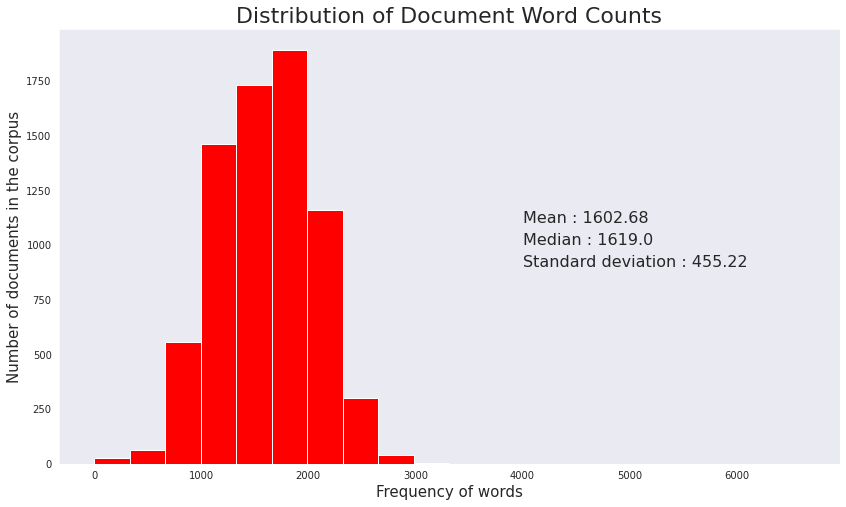

In [32]:
docs_counts = [len(x) for x in dominant_topic['Text']]

##Plotting the same
plt.figure(figsize=(14,8))
plt.hist(docs_counts, bins=20, color = 'r')
plt.text(4010,1100, "Mean : " + str(round(np.mean(docs_counts),2)),fontsize=16 )
plt.text(4010,1000, "Median : " + str(round(np.median(docs_counts),2)),fontsize=16)
plt.text(4010,900, "Standard deviation : " + str(round(np.std(docs_counts),2)),fontsize=16)
plt.ylabel('Number of documents in the corpus',fontsize=15)
plt.xlabel('Frequency of words',fontsize=15)
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

In [33]:
papers.head(1)

,id,year,title,event_type,pdf_name,abstract,paper_text,No._of_words,cleaned_title,cleaned_text
0,1,1987,Self-Organization of Associative Database and Its Applications,NaN,1-self-organization-of-associative-database-and-its-applications.pdf,Abstract Missing,"767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABASE\nAND ITS APPLICATIONS\nHisashi Suzuki and Suguru Arimoto\nOsaka University, Toyonaka, Osaka 560, Japan\nABSTRACT\nAn efficient method of self-organizing associative databases is proposed together with\napplications to robot eyesight systems. The p...",3703,selforganization associative database applications,selforganization associative database applications hisashi suzuki suguru arimoto osaka university toyonaka osaka japan abstract efficient method selforganizing associative databases proposed together applications robot eyesight systems proposed databases associate input output first half part ...


### **Proportion of documents by Dominant Topics (first 6)**

Here we wil just focus on 5 topics

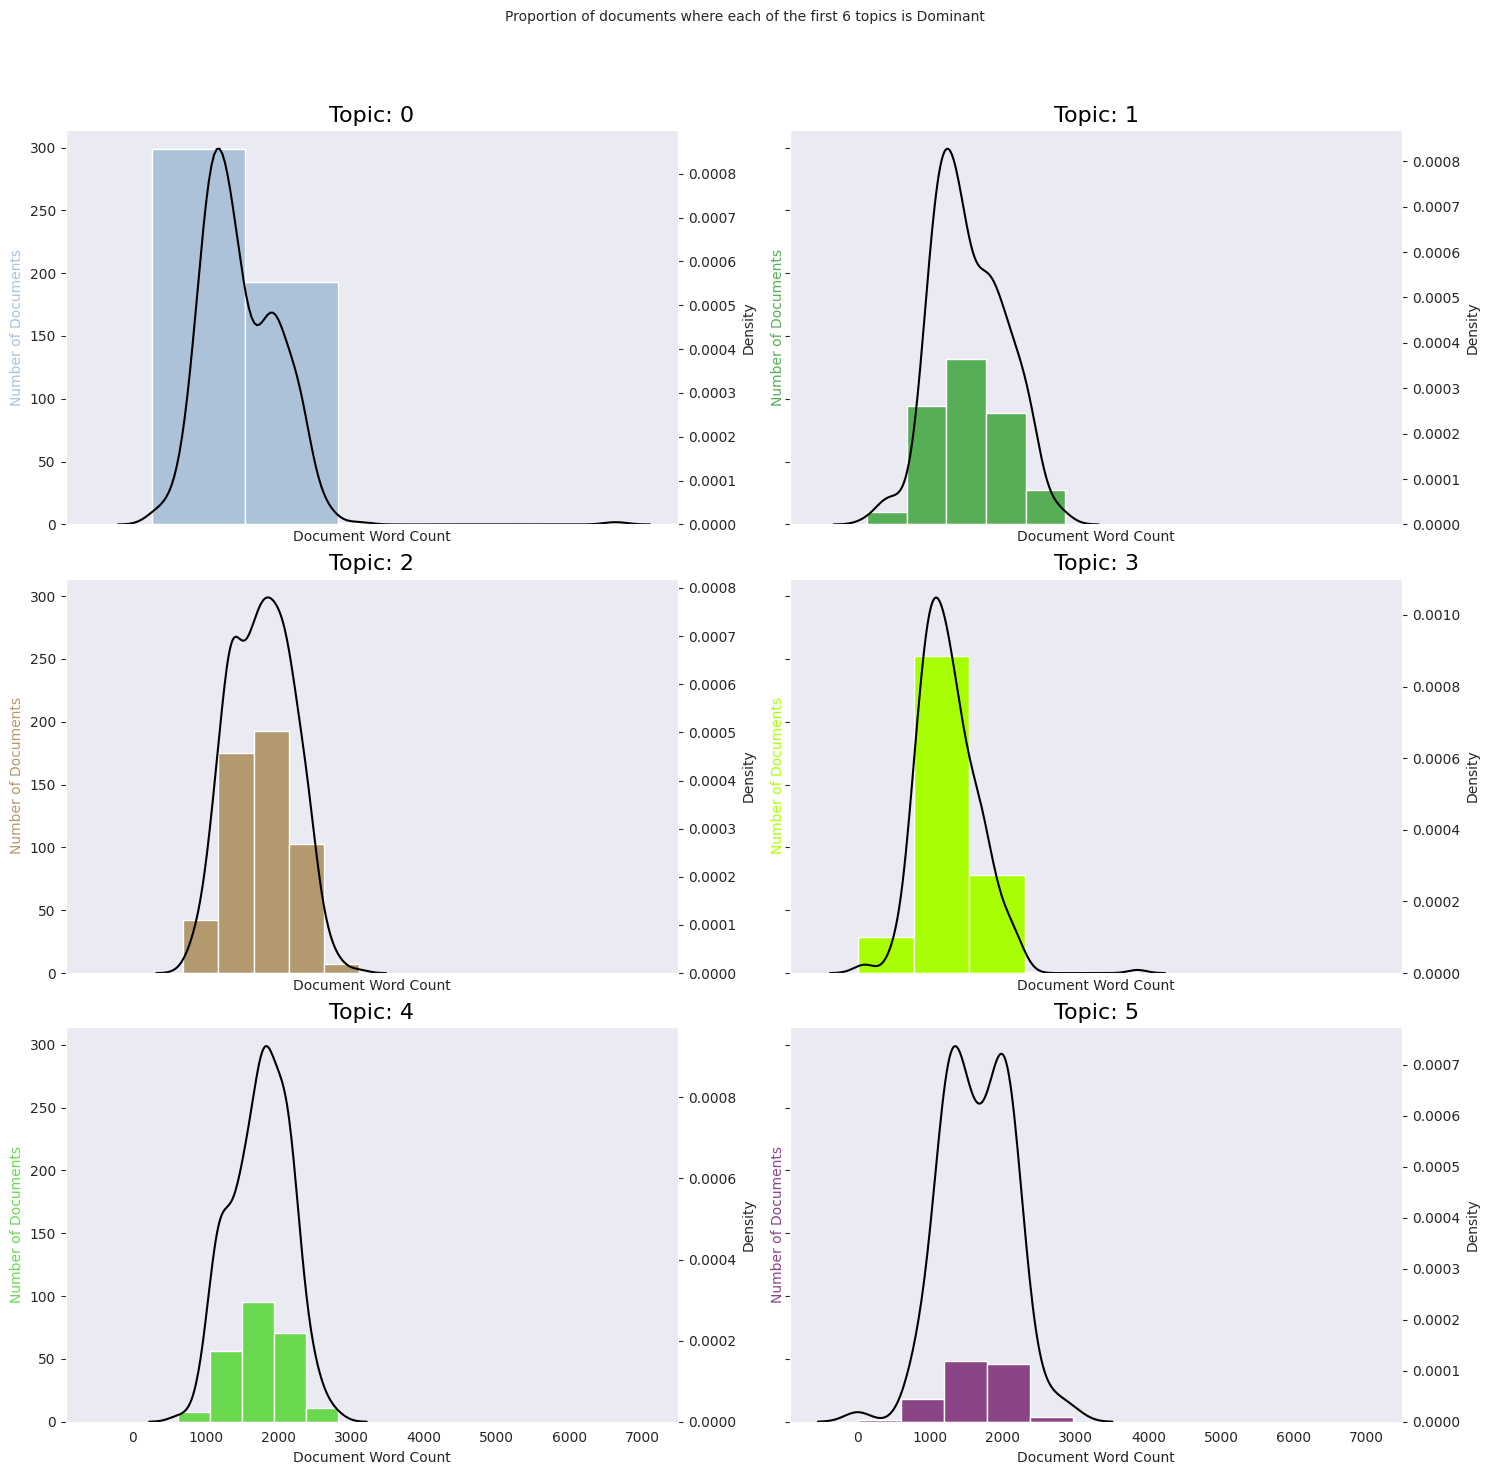

In [34]:
colours = [color for name,color in mcolors.XKCD_COLORS.items()] ## getting more colours

fig,axes = plt.subplots(3,2, figsize = (15,15),dpi=100,sharex=True,sharey=True)
for i,ax in enumerate(axes.flatten()):
  dominant_topic_part = dominant_topic.loc[dominant_topic.Dominant_Topic==i,:]
  docs_len = [len(x) for x in dominant_topic_part['Text']]
  ax.hist(docs_len,bins=5,color = colours[i])
  sns.kdeplot(docs_len, color="black", shade=False,ax=ax.twinx())
  ax.set_xlabel('Document Word Count')
  ax.set_ylabel('Number of Documents', color=colours[i])
  ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color='black'))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
fig.suptitle('Proportion of documents where each of the first 6 topics is Dominant', fontsize=10)
plt.show()



## **WordClouds for Topics' Keywords**

**Top 10 words in the first 10 topics**

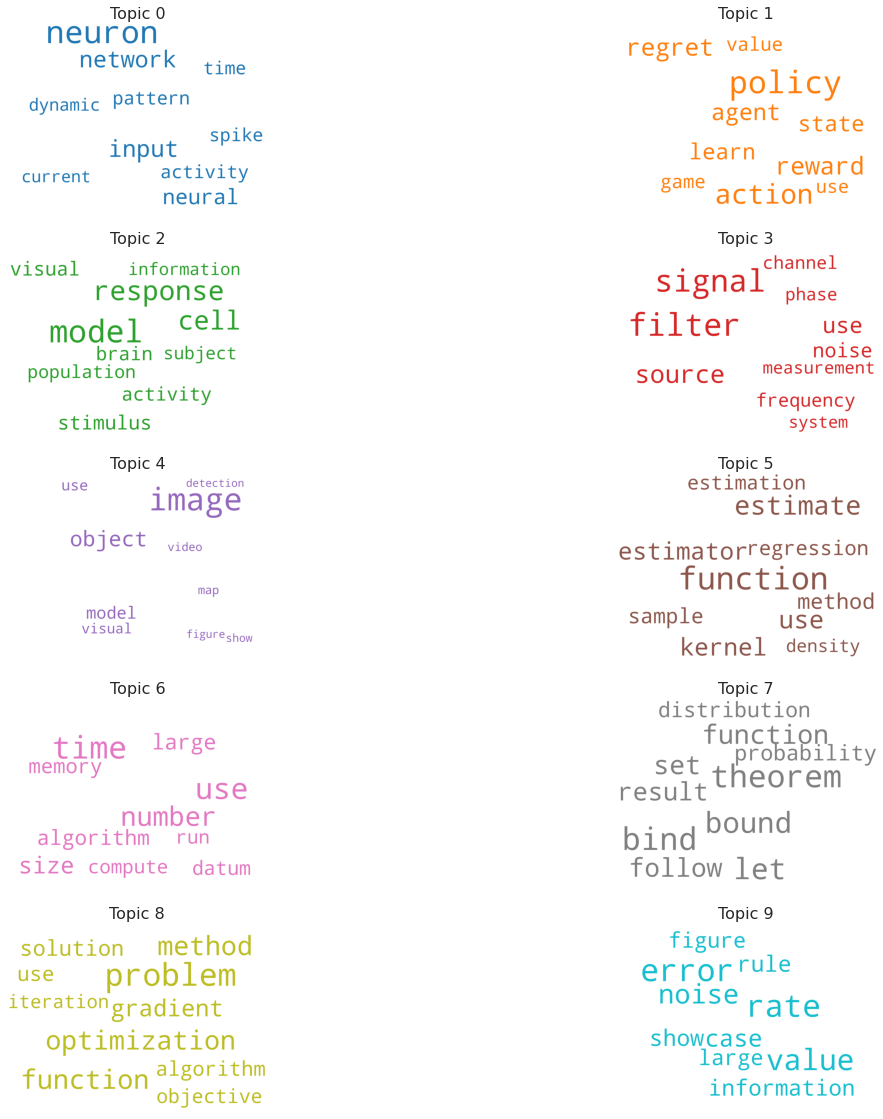

In [35]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = final_lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

In [36]:
papers.head(1)

,id,year,title,event_type,pdf_name,abstract,paper_text,No._of_words,cleaned_title,cleaned_text
0,1,1987,Self-Organization of Associative Database and Its Applications,NaN,1-self-organization-of-associative-database-and-its-applications.pdf,Abstract Missing,"767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABASE\nAND ITS APPLICATIONS\nHisashi Suzuki and Suguru Arimoto\nOsaka University, Toyonaka, Osaka 560, Japan\nABSTRACT\nAn efficient method of self-organizing associative databases is proposed together with\napplications to robot eyesight systems. The p...",3703,selforganization associative database applications,selforganization associative database applications hisashi suzuki suguru arimoto osaka university toyonaka osaka japan abstract efficient method selforganizing associative databases proposed together applications robot eyesight systems proposed databases associate input output first half part ...


## **Word Count & Weights of Topic keywords (Graphical representation)**

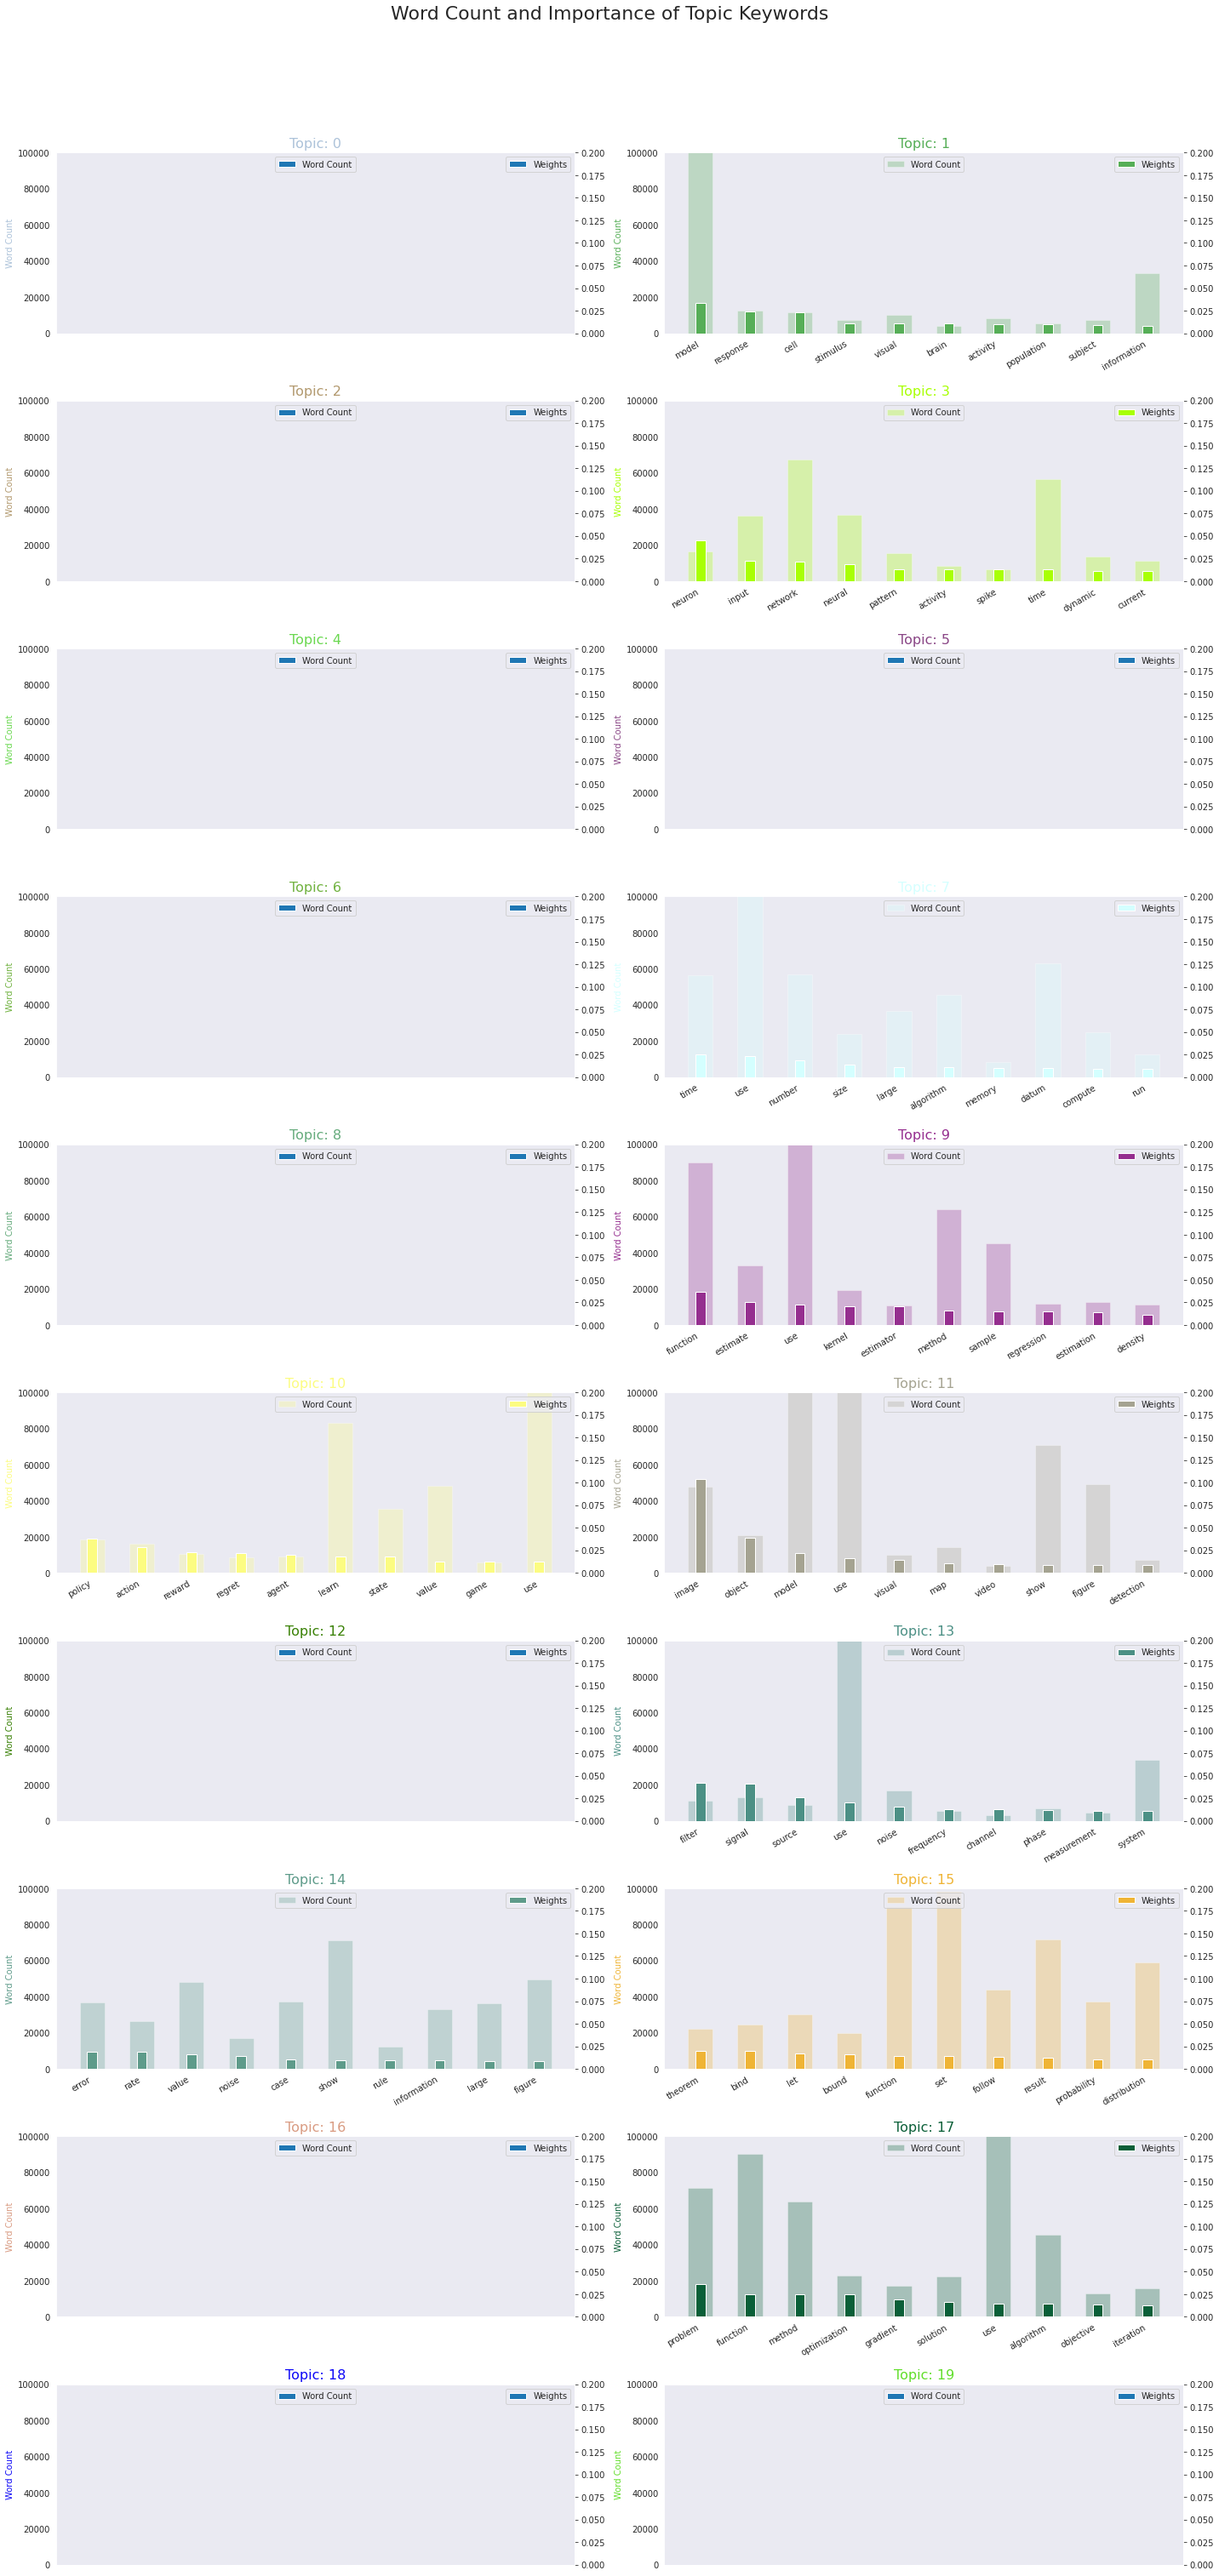

In [37]:
from collections import Counter
topics = final_lda_model.show_topics(formatted=False)
count = Counter([w for w_list in data_bigram for w in w_list])

result=[]
for i,topic in topics:
  for word,weight in topic:
    result.append([i,word,weight,count[word]])

df = pd.DataFrame(result,columns = ['Topic_no', 'Word','Importance','Frequency'])

# Plot Word Count and Weights of Topic Keywords

fig,axes = plt.subplots(10,2,figsize=(20,40))
cols = [color for name,color in mcolors.XKCD_COLORS.items()] 

for i, ax in enumerate(axes.flatten()):
  ax.bar('Word','Frequency',data = df.loc[df['Topic_no']==i,:], color = cols[i], width=0.5, alpha=0.3, label='Word Count')
  ax_twin = ax.twinx()
  ax_twin.bar(x='Word', height="Importance", data=df.loc[df.Topic_no==i, :], color=cols[i], width=0.2, label='Weights')
  ax.set_ylabel('Word Count', color=cols[i])
  ax_twin.set_ylim(0, 0.2); ax.set_ylim(0, 100000)
  ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
  ax.tick_params(axis='y', left=False)
  ax.set_xticklabels(df.loc[df.Topic_no==i, 'Word'], rotation=30, horizontalalignment= 'right')
  ax.legend(loc=9); ax_twin.legend(loc='best')


fig.tight_layout()
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
plt.show()

In [38]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corp_select = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corp_select):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=final_lda_model, corpus=doc_term_mat, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in final_lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

## **Documents pertaining to each of the topics**

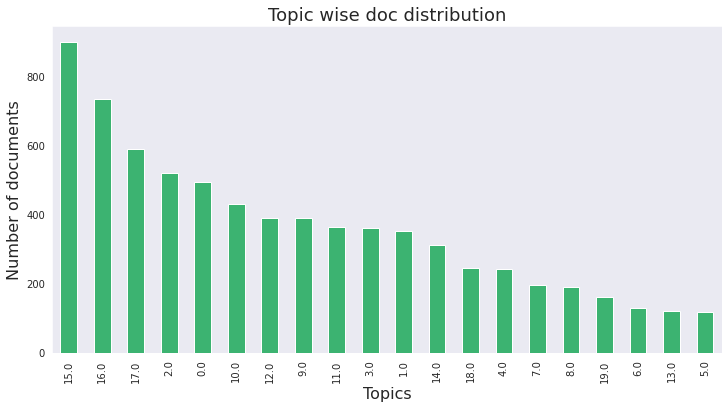

In [60]:
plt.figure(figsize=(22,23))
topic_counts = dominant_topic["Dominant_Topic"].value_counts()
y=topic_counts.plot(kind = "bar", color = "mediumseagreen", figsize = (12,6))
plt.title("Topic wise doc distribution", size = 18)
plt.xlabel("Topics", size = 16)
plt.ylabel("Number of documents", size = 16)
plt.show()

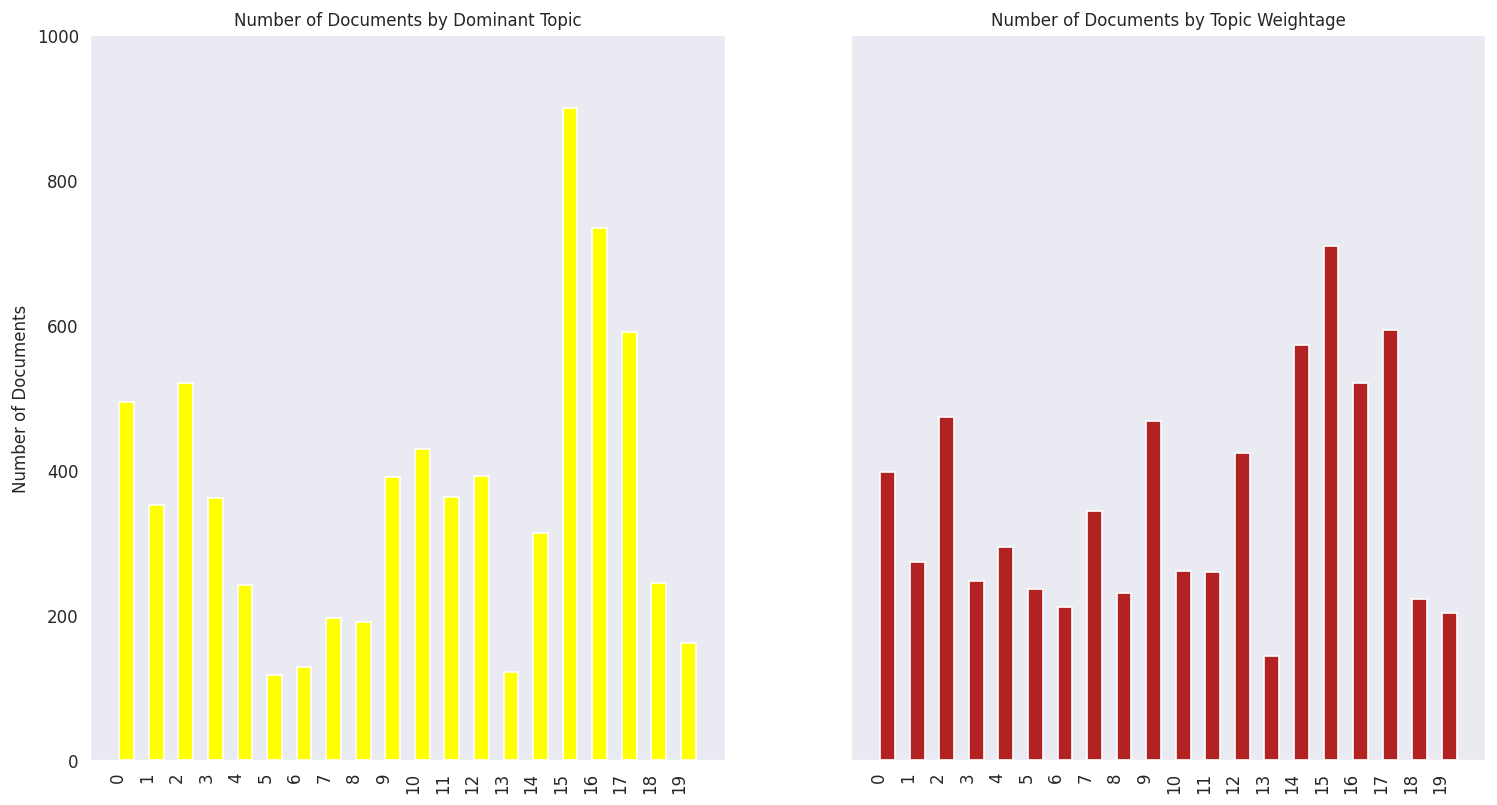

In [40]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 8), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='yellow')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
ax1.set_xticklabels(df_dominant_topic_in_each_doc['Dominant_Topic'], rotation=90, horizontalalignment= 'right')
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='firebrick')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.set_xticklabels(df_dominant_topic_in_each_doc['Dominant_Topic'], rotation=90, horizontalalignment= 'right')
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

**Hence the following conclusions could be made: -**


**1. Topic 15 is the most dominant topic across the corpus or the NIPS papers.**

**2. Topic 5 is the least found topic in the corpus.**

**3. In terms of the topic weightage, topic 13 has the least weightage while Topic 15 still leads in this aspect as well.**




# **Visualization**

In [58]:
# !pip install pyLDAvis
from google.colab import files
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
x = gensimvis.prepare(final_lda_model, doc_term_mat, dictionary=dict_)
x

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
15    -0.155099 -0.143901       1        1  9.889576
17    -0.153781 -0.054928       2        1  8.401367
16    -0.058577 -0.026181       3        1  7.601959
14    -0.010726 -0.123958       4        1  7.420992
2     -0.114065  0.102536       5        1  7.086898
9     -0.122991 -0.019865       6        1  6.310820
12    -0.089934  0.029600       7        1  5.864939
0      0.050735  0.035407       8        1  5.228869
7     -0.070936  0.016607       9        1  4.895768
4     -0.052644 -0.045797      10        1  4.476026
10    -0.052756 -0.096857      11        1  4.093635
11     0.103434  0.164892      12        1  3.992717
1      0.200681  0.015649      13        1  3.654625
18     0.034376  0.087485      14        1  3.591710
8     -0.080303  0.044083      15        1  3.470134
5      0.104368 -0.122081      16        1  3.420663
6     -0.055376  0.208849      17        1  3.047949
3      0.226392 -0.136633      18        1  2.835002
19     0.181329 -0.027803      19        1  2.772565
13     0.115871  0.092897      20        1  1.943784, topic_info=             Term           Freq          Total Category  logprob  loglift
345         model  156342.000000  156342.000000  Default  30.0000  30.0000
263         image   48958.000000   48958.000000  Default  29.0000  29.0000
361       network   67260.000000   67260.000000  Default  28.0000  28.0000
925       feature   44685.000000   44685.000000  Default  27.0000  27.0000
1546      cluster   26160.000000   26160.000000  Default  26.0000  26.0000
...           ...            ...            ...      ...      ...      ...
470        result    1704.136322   71216.261636  Topic20  -4.8856   0.2079
277   information    1348.668411   37210.091892  Topic20  -5.1195   0.6231
127         datum    1258.134121   60771.006803  Topic20  -5.1890   0.0631
681     different    1150.451863   38154.224109  Topic20  -5.2785   0.4391
382        output    1125.687478   26774.212358  Topic20  -5.3003   0.7715

[1518 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
14392      8  0.995294  ablation_study
7148      20  1.001695        abnormal
1          2  0.833082      accelerate
1          9  0.161417      accelerate
1         19  0.005432      accelerate
...      ...       ...             ...
609       18  0.008098            work
609       19  0.009769            work
609       20  0.016733            work
5710       5  0.999888          worker
4262      14  0.999943          writer

[4876 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 18, 17, 15, 3, 10, 13, 1, 8, 5, 11, 12, 2, 19, 9, 6, 7, 4, 20, 14])

1. Each bubble represents a topic. The larger the bubble, the higher percentage of the number of docs in the corpus is about that topic.
2. Blue bars represent the overall frequency of each word in the corpus. If no topic is selected, the blue bars of the most frequently used words will be displayed.
3. Red bars give the estimated number of times a given term was generated by a given topic.
